In [ ]:
### 

In [1]:
from datasketch import MinHash, MinHashLSH
from tqdm.notebook import tqdm
import pandas as pd
import re

pd.set_option('display.max_colwidth', None)

In [2]:
raw_tweets = """
@3dprintfeed·Sep 20, 2015, 1
An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://ift.tt/1KrJeP6

@CasburnBrett·Sep 20, 2015, 0
Italian manufacturer WASP debuts a 40-foot-tall 3D printer for use in building materials. I am going to the Prague today. http://bit.ly/1iV0zZG

@3Dable.Sep 20, 2015, 12
BI #3DP: An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://j.mp/1j05cBW #3D #3DPrinting

@RoboticsNewsNow·Sep 20, 2015, 10
An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://ift.tt/1FVrFoF #Robot

@BeisbolVENEZ·Sep 20, 2015, 5
An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://goo.gl/2rbI9t

@RaceReadyJ·Sep 19, 2015, 8
6 awesome ways to bring your kids’ ideas to life with 3D printing http://ift.tt/1QpfmpZ

@Daydreamerdiary·Sep 19, 2015, 11
3D printing and music #instruments - a vision of the #future http://bit.ly/1Kl6mP8 #previoustweet #development #technology #music

@RaphaelLove·Sep 19, 2015, 6
6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7h53

@farhaaanqureshi·Sep 19, 2015, 3
6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7mpZ

@JohnsonSpeer·Sep 19, 2015, 5
6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7jcl

@DHQLounge·Sep 19, 2015, 4
6 awesome ways to bring your #kids&#8217; ideas to life with 3D printing http://goo.gl/fb/AcAu5u #toys #3dprinter

@redcubesoftware·Sep 19, 2015, 7
6 awesome ways to bring your kids’ ideas to life with 3D printing http://mashable.com/2015/09/19/kids-toys-3d-printing/?utm_campaign=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_cid=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_medium=feed&utm_source=rss

@RedlineEntrprse·Sep 19, 2015, 2
6 awesome ways to bring your kids’ ideas to life with 3D printing http://ift.tt/1QpfmpZ

@asveenrai·Sep 19, 2015, 9
6 awesome ways to bring your kids’ ideas to life with 3D printing http://mashable.com/2015/09/19/kids-toys-3d-printing/?utm_campaign=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_cid=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_medium=feed&utm_source=rss

@Panoss_64·Sep 19, 2015, 4
6 awesome ways to bring your #kids&#8217; ideas to life with 3D printing http://goo.gl/fb/vH0ejk #toys #3dprinter

@konokinokoito·Sep 19, 2015, 6
6 awesome ways to bring your kids&#8217; ideas to life with 3D printing http://ift.tt/1ioLCi0

@ship_ETO·Sep 19, 2015, 10
6 awesome ways to bring your kids’ ideas to life with 3D printing:… http://dlvr.it/CC7Y5y #Kids #Toys #3dPrinter #DigitalnaSigurnost

@ViralFox_Inc·Sep 19, 2015, 1
#VFox 6 awesome ways to bring your kids’ ideas to life with 3D printing http://goo.gl/uH8XEH

@3DLT·Sep 19, 2015, 7
6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7Z2F #3Dprinting
"""

In [3]:
def tokenize(text):
    return set(text.lower().split())

def create_minhash(tokens, num_perm=128):
    mh = MinHash(num_perm=num_perm)
    for token in tokens:
        mh.update(token.encode("utf8"))
    return mh
    
def find_near_duplicates(df, text_column="Normalized Text", num_perm=512, threshold=0.7):
    """
    Finds near-duplicate text entries in a DataFrame using MinHash and Locality Sensitive Hashing (LSH).

    MinHash is a technique for quickly estimating the Jaccard similarity between two sets (e.g., sets of words).
    Locality Sensitive Hashing (LSH) allows for efficient approximate nearest neighbor search by hashing similar items
    into the same "buckets" with high probability.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing text data to be analyzed for near duplicates.

    text_column : str, default="Normalized Text"
        The name of the column in the DataFrame that contains the normalized text (e.g., lowercase, URL-removed tweets).
        This text will be tokenized and used to compute MinHash signatures.

    num_perm : int, default=256
        The number of hash permutations used in the MinHash signature.
        - Higher values (e.g., 256 or 512) improve the accuracy of the estimated Jaccard similarity between sets.
        - Lower values (e.g., 64 or 128) reduce computation and memory usage but are less accurate.

    threshold : float, default=0.8
        The Jaccard similarity threshold (between 0 and 1) for considering two texts as near duplicates.
        - A value of 0.8 means only pairs with 80% or more token overlap (approximate) will be considered duplicates.
        - Lower this value to find looser matches; raise it to be more strict.

    Returns
    -------
    duplicates_df : pandas.DataFrame
        A DataFrame containing pairs of near-duplicate text entries with the following columns:
        - Index_1, Tweet_1: index and text of the first duplicate
        - Index_2, Tweet_2: index and text of the second duplicate
        - Approx_Jaccard: the threshold used for similarity comparison

    Notes
    -----
    - This function assumes that the input text has been preprocessed (e.g., lowercased, punctuation removed).
    - Tokens are generated by simple whitespace splitting. For better results, consider using custom tokenization.
    - The result is symmetric: if (A, B) is a pair, (B, A) will not be repeated.

    Example
    -------
    >>> duplicates = find_near_duplicates(df, text_column="Normalized Texts", num_perm=256, threshold=0.85)
    >>> print(duplicates.head())
    """
    from datasketch import MinHash, MinHashLSH
    from tqdm.notebook import tqdm
    import pandas as pd

    def tokenize(text):
        return set(text.lower().split())

    def create_minhash(tokens, num_perm=128):
        mh = MinHash(num_perm=num_perm)
        for token in tokens:
            mh.update(token.encode("utf8"))
        return mh

    df = df.copy()
    df["tokens"] = df[text_column].apply(tokenize)

    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhash_dict = {}

    print("Building MinHash signatures and inserting into LSH...")
    for i, row in tqdm(df.iterrows(), total=len(df), desc="MinHash & LSH Insertion"):
        mh = create_minhash(row["tokens"], num_perm=num_perm)
        minhash_dict[i] = mh
        lsh.insert(str(i), mh)
    print("LSH index built.")

    print("Finding near-duplicate pairs...")
    similar_pairs = []
    for i in tqdm(df.index, total=len(df), desc="Finding near-duplicate pairs"):
        mh = minhash_dict[i]
        result = lsh.query(mh)
        dup_indices = [int(x) for x in result if int(x) != int(i)]

        for j in dup_indices:
            similar_pairs.append({
                "Index_1": i,
                "Tweet_1": df.loc[i, text_column],
                "Index_2": j,
                "Tweet_2": df.loc[j, text_column],
                "Approx_Jaccard": threshold,
            })

    duplicates_df = pd.DataFrame(similar_pairs)
    duplicates_df["Pair"] = duplicates_df.apply(
        lambda row: tuple(sorted([row["Index_1"], row["Index_2"]])), axis=1
    )
    duplicates_df.drop_duplicates("Pair", inplace=True)
    duplicates_df.drop(columns="Pair", inplace=True)

    print("Number of near-duplicate pairs found:", len(duplicates_df))
    return duplicates_df


def remove_duplicates_keep_highest_engagement(df, duplicates_df, engagement_column="engagement"):
    """
    Memory-efficient function to remove near-duplicate entries from a DataFrame,
    keeping only the entry with the highest engagement value from each group.
    
    Works with large datasets under limited RAM constraints.
    """
    import pandas as pd
    import networkx as nx
    
    # Process duplicates in smaller chunks to reduce memory usage
    chunk_size = 10000
    
    # Create a graph to identify connected components (groups of duplicates)
    G = nx.Graph()
    
    # Add all unique indices as nodes
    all_indices = set(duplicates_df["Index_1"]).union(set(duplicates_df["Index_2"]))
    G.add_nodes_from(all_indices)
    
    # Add edges between duplicate pairs in chunks
    for i in range(0, len(duplicates_df), chunk_size):
        chunk = duplicates_df.iloc[i:i+chunk_size]
        for _, row in chunk.iterrows():
            G.add_edge(row["Index_1"], row["Index_2"])
    
    # Find connected components (groups of duplicates)
    duplicate_groups = list(nx.connected_components(G))
    print(f"Found {len(duplicate_groups)} groups of near-duplicates")
    
    # Process groups in batches to reduce memory usage
    indices_to_remove = []
    batch_size = 1000  # Process this many groups at once
    
    for i in range(0, len(duplicate_groups), batch_size):
        batch_groups = duplicate_groups[i:i+batch_size]
        
        for group in batch_groups:
            group_indices = list(group)
            
            # Instead of loading all group data at once, just extract engagement values
            group_engagements = df.loc[group_indices, engagement_column]
            
            # Find the index with highest engagement
            max_engagement_idx = group_engagements.idxmax()
            
            # Add other indices to removal list
            group_indices.remove(max_engagement_idx)
            indices_to_remove.extend(group_indices)
        
        # Explicitly clear variables to free memory
        del batch_groups
        del group_engagements
    
    print(f"Removing {len(indices_to_remove)} duplicates")
    
    # Create a new dataframe with duplicates removed, this is more memory efficient
    # than creating a new dataframe with only the rows to keep
    filtered_df = df.drop(indices_to_remove)
    
    return filtered_df


In [4]:
import pandas as pd
import re



# Split by lines and pair every two lines (author+meta, and post)
lines = [line.strip() for line in raw_tweets.strip().split('\n') if line.strip()]
pairs = [(lines[i], lines[i+1]) for i in range(0, len(lines), 2)]

# Extract author ID, post content, and engagement
data = []
for author_line, post_line in pairs:
    author_match = re.match(r'@([\w\.]+)', author_line)
    engagement_match = re.search(r'(\d+)\s*$', author_line)
    
    if author_match:
        author = author_match.group(1)
        engagement = int(engagement_match.group(1)) if engagement_match else 0
        data.append({
            'author_id': author,
            'post': post_line,
            'engagement': engagement
        })

# Create DataFrame
df = pd.DataFrame(data)
df


,author_id,post,engagement
0,3dprintfeed,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://ift.tt/1KrJeP6,1
1,CasburnBrett,Italian manufacturer WASP debuts a 40-foot-tall 3D printer for use in building materials. I am going to the Prague today. http://bit.ly/1iV0zZG,0
2,3Dable.Sep,BI #3DP: An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://j.mp/1j05cBW #3D #3DPrinting,12
3,RoboticsNewsNow,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://ift.tt/1FVrFoF #Robot,10
4,BeisbolVENEZ,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://goo.gl/2rbI9t,5
5,RaceReadyJ,6 awesome ways to bring your kids’ ideas to life with 3D printing http://ift.tt/1QpfmpZ,8
6,Daydreamerdiary,3D printing and music #instruments - a vision of the #future http://bit.ly/1Kl6mP8 #previoustweet #development #technology #music,11
7,RaphaelLove,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7h53,6
8,farhaaanqureshi,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7mpZ,3
9,JohnsonSpeer,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7jcl,5


In [5]:
df["Normalized Texts"] = df["post"].str.lower().str.replace(r"http\S+", "", regex=True).str.strip()
df

,author_id,post,engagement,Normalized Texts
0,3dprintfeed,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://ift.tt/1KrJeP6,1,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis
1,CasburnBrett,Italian manufacturer WASP debuts a 40-foot-tall 3D printer for use in building materials. I am going to the Prague today. http://bit.ly/1iV0zZG,0,italian manufacturer wasp debuts a 40-foot-tall 3d printer for use in building materials. i am going to the prague today.
2,3Dable.Sep,BI #3DP: An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://j.mp/1j05cBW #3D #3DPrinting,12,bi #3dp: an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #3d #3dprinting
3,RoboticsNewsNow,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://ift.tt/1FVrFoF #Robot,10,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #robot
4,BeisbolVENEZ,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://goo.gl/2rbI9t,5,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis
5,RaceReadyJ,6 awesome ways to bring your kids’ ideas to life with 3D printing http://ift.tt/1QpfmpZ,8,6 awesome ways to bring your kids’ ideas to life with 3d printing
6,Daydreamerdiary,3D printing and music #instruments - a vision of the #future http://bit.ly/1Kl6mP8 #previoustweet #development #technology #music,11,3d printing and music #instruments - a vision of the #future #previoustweet #development #technology #music
7,RaphaelLove,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7h53,6,6 awesome ways to bring your kids’ ideas to life with 3d printing
8,farhaaanqureshi,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7mpZ,3,6 awesome ways to bring your kids’ ideas to life with 3d printing
9,JohnsonSpeer,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7jcl,5,6 awesome ways to bring your kids’ ideas to life with 3d printing


In [6]:
# Show all duplicates
duplicates = df[df.duplicated(subset="Normalized Texts", keep=False)]
print("Duplicates found:")
duplicates


Duplicates found:


,author_id,post,engagement,Normalized Texts
0,3dprintfeed,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://ift.tt/1KrJeP6,1,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis
4,BeisbolVENEZ,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://goo.gl/2rbI9t,5,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis
5,RaceReadyJ,6 awesome ways to bring your kids’ ideas to life with 3D printing http://ift.tt/1QpfmpZ,8,6 awesome ways to bring your kids’ ideas to life with 3d printing
7,RaphaelLove,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7h53,6,6 awesome ways to bring your kids’ ideas to life with 3d printing
8,farhaaanqureshi,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7mpZ,3,6 awesome ways to bring your kids’ ideas to life with 3d printing
9,JohnsonSpeer,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7jcl,5,6 awesome ways to bring your kids’ ideas to life with 3d printing
10,DHQLounge,6 awesome ways to bring your #kids&#8217; ideas to life with 3D printing http://goo.gl/fb/AcAu5u #toys #3dprinter,4,6 awesome ways to bring your #kids&#8217; ideas to life with 3d printing #toys #3dprinter
11,redcubesoftware,6 awesome ways to bring your kids’ ideas to life with 3D printing http://mashable.com/2015/09/19/kids-toys-3d-printing/?utm_campaign=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_cid=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_medium=feed&utm_source=rss,7,6 awesome ways to bring your kids’ ideas to life with 3d printing
12,RedlineEntrprse,6 awesome ways to bring your kids’ ideas to life with 3D printing http://ift.tt/1QpfmpZ,2,6 awesome ways to bring your kids’ ideas to life with 3d printing
13,asveenrai,6 awesome ways to bring your kids’ ideas to life with 3D printing http://mashable.com/2015/09/19/kids-toys-3d-printing/?utm_campaign=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_cid=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_medium=feed&utm_source=rss,9,6 awesome ways to bring your kids’ ideas to life with 3d printing


In [7]:
# Drop duplicates, keeping the one with the highest engagement
df = df.sort_values("engagement", ascending=False)
df = df.drop_duplicates(subset="Normalized Texts", keep="first").reset_index(drop=True)

# Show final result
print("\nCleaned DataFrame (kept highest engagement per duplicate):")
df


Cleaned DataFrame (kept highest engagement per duplicate):


,author_id,post,engagement,Normalized Texts
0,3Dable.Sep,BI #3DP: An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://j.mp/1j05cBW #3D #3DPrinting,12,bi #3dp: an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #3d #3dprinting
1,Daydreamerdiary,3D printing and music #instruments - a vision of the #future http://bit.ly/1Kl6mP8 #previoustweet #development #technology #music,11,3d printing and music #instruments - a vision of the #future #previoustweet #development #technology #music
2,RoboticsNewsNow,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://ift.tt/1FVrFoF #Robot,10,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #robot
3,ship_ETO,6 awesome ways to bring your kids’ ideas to life with 3D printing:… http://dlvr.it/CC7Y5y #Kids #Toys #3dPrinter #DigitalnaSigurnost,10,6 awesome ways to bring your kids’ ideas to life with 3d printing:… #kids #toys #3dprinter #digitalnasigurnost
4,asveenrai,6 awesome ways to bring your kids’ ideas to life with 3D printing http://mashable.com/2015/09/19/kids-toys-3d-printing/?utm_campaign=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_cid=Mash-Prod-RSS-Feedburner-Tech-Partial&utm_medium=feed&utm_source=rss,9,6 awesome ways to bring your kids’ ideas to life with 3d printing
5,3DLT,6 awesome ways to bring your kids’ ideas to life with 3D printing http://dlvr.it/CC7Z2F #3Dprinting,7,6 awesome ways to bring your kids’ ideas to life with 3d printing #3dprinting
6,konokinokoito,6 awesome ways to bring your kids&#8217; ideas to life with 3D printing http://ift.tt/1ioLCi0,6,6 awesome ways to bring your kids&#8217; ideas to life with 3d printing
7,BeisbolVENEZ,An Italian company built a 40-foot tall 3D printer to help solve the global housing crisis http://goo.gl/2rbI9t,5,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis
8,DHQLounge,6 awesome ways to bring your #kids&#8217; ideas to life with 3D printing http://goo.gl/fb/AcAu5u #toys #3dprinter,4,6 awesome ways to bring your #kids&#8217; ideas to life with 3d printing #toys #3dprinter
9,ViralFox_Inc,#VFox 6 awesome ways to bring your kids’ ideas to life with 3D printing http://goo.gl/uH8XEH,1,#vfox 6 awesome ways to bring your kids’ ideas to life with 3d printing


In [8]:
df.drop(columns=["post"], inplace=True)
df

,author_id,engagement,Normalized Texts
0,3Dable.Sep,12,bi #3dp: an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #3d #3dprinting
1,Daydreamerdiary,11,3d printing and music #instruments - a vision of the #future #previoustweet #development #technology #music
2,RoboticsNewsNow,10,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #robot
3,ship_ETO,10,6 awesome ways to bring your kids’ ideas to life with 3d printing:… #kids #toys #3dprinter #digitalnasigurnost
4,asveenrai,9,6 awesome ways to bring your kids’ ideas to life with 3d printing
5,3DLT,7,6 awesome ways to bring your kids’ ideas to life with 3d printing #3dprinting
6,konokinokoito,6,6 awesome ways to bring your kids&#8217; ideas to life with 3d printing
7,BeisbolVENEZ,5,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis
8,DHQLounge,4,6 awesome ways to bring your #kids&#8217; ideas to life with 3d printing #toys #3dprinter
9,ViralFox_Inc,1,#vfox 6 awesome ways to bring your kids’ ideas to life with 3d printing


In [9]:
df_preduplicated = df

In [10]:
#df.drop(columns=["post"], inplace=True)
duplicates_df = find_near_duplicates(df, text_column="Normalized Texts")

Building MinHash signatures and inserting into LSH...


MinHash & LSH Insertion:   0%|          | 0/11 [00:00<?, ?it/s]

LSH index built.
Finding near-duplicate pairs...


Finding near-duplicate pairs:   0%|          | 0/11 [00:00<?, ?it/s]

Number of near-duplicate pairs found: 9


In [11]:
duplicates_df

,Index_1,Tweet_1,Index_2,Tweet_2,Approx_Jaccard
0,0,bi #3dp: an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #3d #3dprinting,7,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis,0.7
1,0,bi #3dp: an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #3d #3dprinting,2,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #robot,0.7
2,2,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #robot,7,an italian company built a 40-foot tall 3d printer to help solve the global housing crisis,0.7
4,4,6 awesome ways to bring your kids’ ideas to life with 3d printing,6,6 awesome ways to bring your kids&#8217; ideas to life with 3d printing,0.7
5,4,6 awesome ways to bring your kids’ ideas to life with 3d printing,9,#vfox 6 awesome ways to bring your kids’ ideas to life with 3d printing,0.7
6,4,6 awesome ways to bring your kids’ ideas to life with 3d printing,5,6 awesome ways to bring your kids’ ideas to life with 3d printing #3dprinting,0.7
7,5,6 awesome ways to bring your kids’ ideas to life with 3d printing #3dprinting,6,6 awesome ways to bring your kids&#8217; ideas to life with 3d printing,0.7
9,5,6 awesome ways to bring your kids’ ideas to life with 3d printing #3dprinting,9,#vfox 6 awesome ways to bring your kids’ ideas to life with 3d printing,0.7
11,6,6 awesome ways to bring your kids&#8217; ideas to life with 3d printing,9,#vfox 6 awesome ways to bring your kids’ ideas to life with 3d printing,0.7


In [12]:
df = remove_duplicates_keep_highest_engagement(df, duplicates_df, engagement_column="engagement")
df

Found 2 groups of near-duplicates
Removing 5 duplicates


,author_id,engagement,Normalized Texts
0,3Dable.Sep,12,bi #3dp: an italian company built a 40-foot tall 3d printer to help solve the global housing crisis #3d #3dprinting
1,Daydreamerdiary,11,3d printing and music #instruments - a vision of the #future #previoustweet #development #technology #music
3,ship_ETO,10,6 awesome ways to bring your kids’ ideas to life with 3d printing:… #kids #toys #3dprinter #digitalnasigurnost
4,asveenrai,9,6 awesome ways to bring your kids’ ideas to life with 3d printing
8,DHQLounge,4,6 awesome ways to bring your #kids&#8217; ideas to life with 3d printing #toys #3dprinter
10,CasburnBrett,0,italian manufacturer wasp debuts a 40-foot-tall 3d printer for use in building materials. i am going to the prague today.


In [16]:
def plot_simplified_duplicate_network(duplicates_df, df=None, engagement_column=None, sample_size=None):
    """
    Visualizes only the network of near-duplicate clusters.

    Parameters:
    -----------
    duplicates_df : DataFrame
        Output of find_near_duplicates()
    df : DataFrame, optional
        Original dataset with engagement scores
    engagement_column : str, optional
        Name of the engagement column
    sample_size : int, optional
        Number of duplicate pairs to sample for faster rendering

    Returns:
    --------
    None – displays the network graph
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np

    # Sample for large datasets
    if sample_size and sample_size < len(duplicates_df):
        viz_df = duplicates_df.sample(sample_size, random_state=42)
        print(f"Sampled {sample_size} of {len(duplicates_df)} duplicate pairs")
    else:
        viz_df = duplicates_df

    # Build graph
    G = nx.Graph()
    for _, row in viz_df.iterrows():
        G.add_edge(row["Index_1"], row["Index_2"])

    # Layout for plotting
    pos = nx.spring_layout(G, seed=42)

    # Node color: by engagement or degree
    if df is not None and engagement_column:
        node_colors = [df.loc[n, engagement_column] if n in df.index else 0 for n in G.nodes]
        label = "Engagement"
        cmap = plt.cm.viridis
    else:
        degrees = dict(G.degree())
        node_colors = [degrees[n] for n in G.nodes]
        label = "Number of Near-Duplicates"
        cmap = plt.cm.YlOrRd

    # Normalize color scale
    norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Setup plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Draw graph on the specific Axes
    nx.draw_networkx(
        G, pos, ax=ax, with_labels=True, node_color=node_colors, cmap=cmap,
        edge_color="gray", node_size=150, font_size=8, alpha=0.8
    )

    # Colorbar attached to this axes
    fig.colorbar(sm, ax=ax, label=label)

    ax.set_title("Network of Near-Duplicate Pairs")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


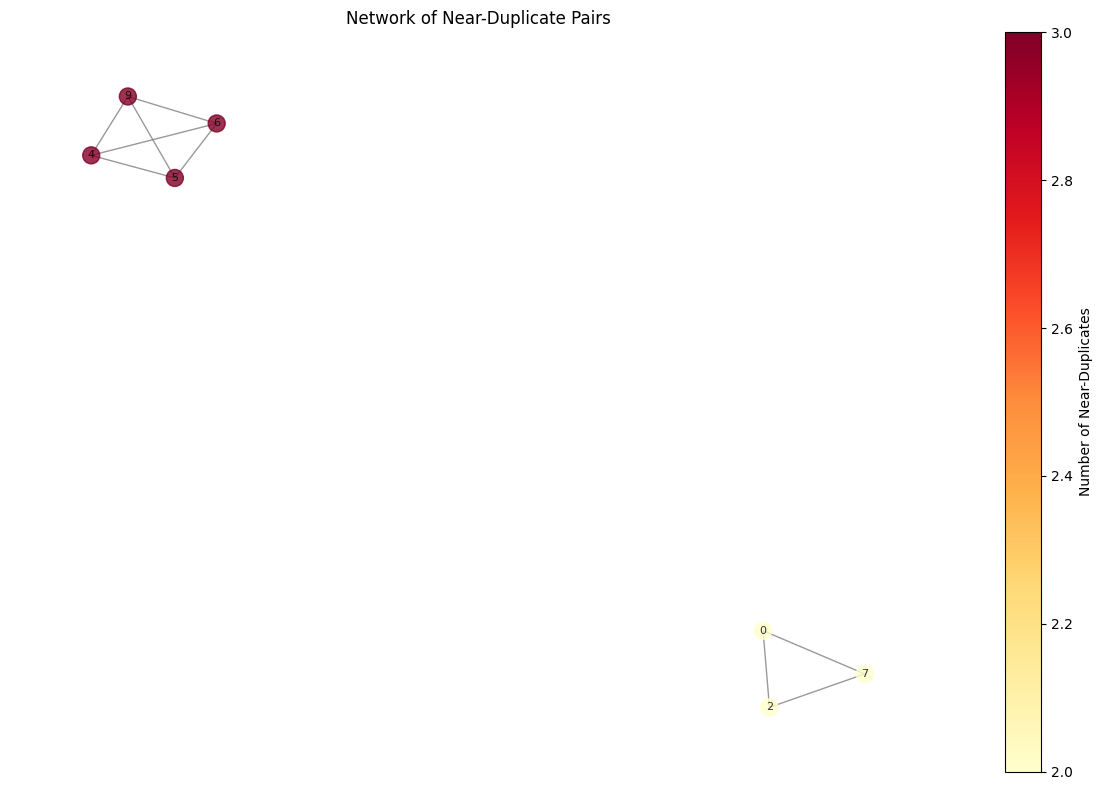

In [17]:
plot_simplified_duplicate_network(duplicates_df)

In [26]:
def plot_simplified_duplicate_network(
    duplicates_df, df=None, sample_size=None
):
    """
    Visualizes the network of near-duplicate clusters with group coloring and a discrete legend.

    Parameters:
    -----------
    duplicates_df : DataFrame
        Output from find_near_duplicates()
    df : DataFrame, optional
        Original dataset (only needed to resolve indices)
    sample_size : int, optional
        Number of duplicate pairs to sample for faster rendering

    Returns:
    --------
    None – displays the network graph
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    import matplotlib.cm as cm
    import matplotlib.patches as mpatches

    # Sample if needed
    if sample_size and sample_size < len(duplicates_df):
        viz_df = duplicates_df.sample(sample_size, random_state=42)
        print(f"Sampled {sample_size} of {len(duplicates_df)} duplicate pairs")
    else:
        viz_df = duplicates_df

    # Build graph
    G = nx.Graph()
    for _, row in viz_df.iterrows():
        G.add_edge(row["Index_1"], row["Index_2"])

    # Layout
    pos = nx.spring_layout(G, seed=42)

    # Identify components (groups)
    components = list(nx.connected_components(G))
    node_to_group = {node: i for i, comp in enumerate(components) for node in comp}
    group_ids = sorted(set(node_to_group.values()))

    # Assign each group a unique color from tab20
    cmap = cm.get_cmap("tab20", len(group_ids))
    group_colors = {group_id: cmap(group_id) for group_id in group_ids}

    # Prepare plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Draw nodes per group (for custom legend)
    for group_id in group_ids:
        nodes_in_group = [n for n in G.nodes if node_to_group[n] == group_id]
        nx.draw_networkx_nodes(
            G, pos, nodelist=nodes_in_group, node_color=[group_colors[group_id]] * len(nodes_in_group),
            node_size=300, alpha=0.9, ax=ax, label=f"Group {group_id}"
        )

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, edge_color="gray", ax=ax, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Add legend manually
    handles = [mpatches.Patch(color=group_colors[g], label=f"Group {g}") for g in group_ids]
    ax.legend(handles=handles, title="Group ID", bbox_to_anchor=(1.02, 1), loc="upper left")

    # Annotation
    ax.text(0.01, 0.01, "⚪ Node numbers = index in the dataset",
            transform=ax.transAxes, fontsize=10, color="dimgray", ha="left")

    ax.set_title("Network of Near-Duplicate Pairs (Grouped)")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_680770/3147196432.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(group_ids))


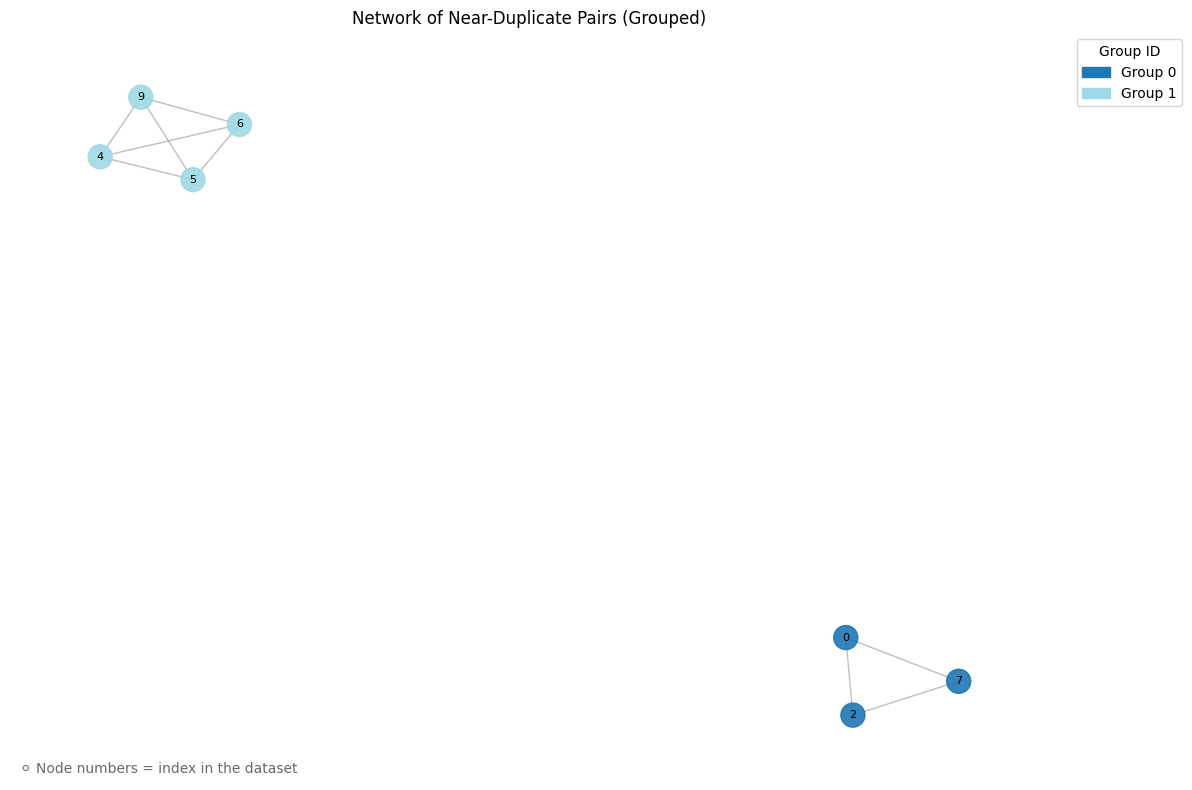

In [27]:
plot_simplified_duplicate_network(duplicates_df)

In [31]:
def plot_simplified_duplicate_network(
    duplicates_df, df=None, sample_size=None, save_path=None
):
    """
    Visualizes the network of near-duplicate clusters with group coloring and a discrete legend.

    Parameters:
    -----------
    duplicates_df : DataFrame
        Output from find_near_duplicates()
    df : DataFrame, optional
        Original dataset (only needed to resolve indices)
    sample_size : int, optional
        Number of duplicate pairs to sample for faster rendering

    Returns:
    --------
    None – displays the network graph
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    import matplotlib.cm as cm
    import matplotlib.patches as mpatches

    # Sample if needed
    if sample_size and sample_size < len(duplicates_df):
        viz_df = duplicates_df.sample(sample_size, random_state=42)
        print(f"Sampled {sample_size} of {len(duplicates_df)} duplicate pairs")
    else:
        viz_df = duplicates_df

    # Build graph
    G = nx.Graph()
    for _, row in viz_df.iterrows():
        G.add_edge(row["Index_1"], row["Index_2"])

    # Layout
    pos = nx.spring_layout(G, seed=42)

    # Identify components (groups)
    components = list(nx.connected_components(G))
    node_to_group = {node: i for i, comp in enumerate(components) for node in comp}
    group_ids = sorted(set(node_to_group.values()))

    # Assign each group a unique color from tab20
    cmap = cm.get_cmap("tab20", len(group_ids))
    group_colors = {group_id: cmap(group_id) for group_id in group_ids}

    # Prepare plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Draw nodes per group (for custom legend)
    for group_id in group_ids:
        nodes_in_group = [n for n in G.nodes if node_to_group[n] == group_id]
        nx.draw_networkx_nodes(
            G, pos, nodelist=nodes_in_group, node_color=[group_colors[group_id]] * len(nodes_in_group),
            node_size=300, alpha=0.9, ax=ax, label=f"Group {group_id}"
        )

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, edge_color="gray", ax=ax, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Add legend
    handles = [mpatches.Patch(color=group_colors[g], label=f"Group {g}") for g in group_ids]
    ax.legend(handles=handles, title="Group ID", bbox_to_anchor=(1.02, 1), loc="upper left")

    # Add prominent annotation about node labels
    ax.text(
        0.01, -0.08,
        "Each node number = index in the dataset",
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        color="darkslategray",
        ha="left"
    )

    # Restore plot border
    for spine in ax.spines.values():
        spine.set_visible(True)

    ax.set_title("Network of Near-Duplicate Pairs (Grouped)", fontsize=14)
    ax.axis("on")  # Show the border frame
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {save_path}")
    plt.show()


/tmp/ipykernel_680770/3114903463.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(group_ids))
/tmp/ipykernel_680770/3114903463.py:85: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_680770/3114903463.py:88: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches="tight")


Plot saved to near_duplicates_network.png


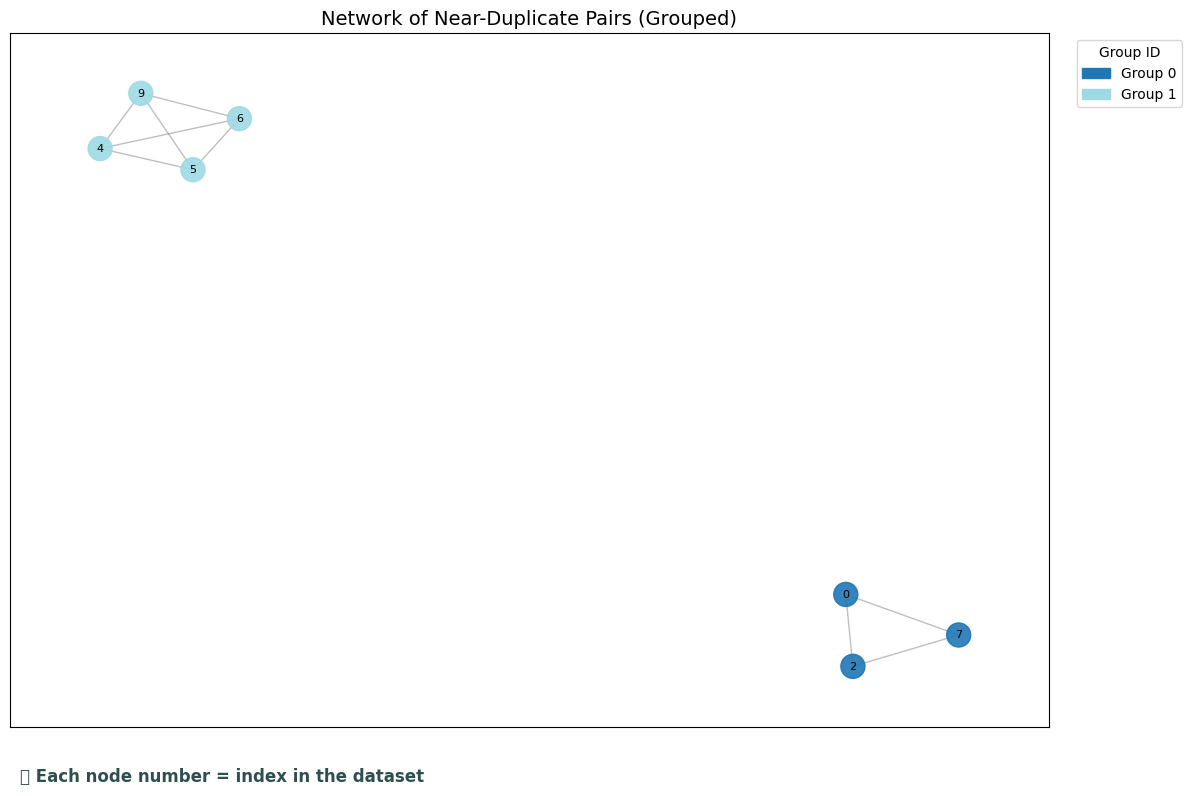

In [33]:
plot_simplified_duplicate_network(duplicates_df, save_path="near_duplicates_network.png")